In [44]:
import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime  
# 读取二进制文件内容
file_name = 'tick_data.csv'
with open(file_name, 'rb') as f:
    result = chardet.detect(f.read())

# 获取检测到的编码格式
encoding = result['encoding']

# 使用检测到的编码格式读取文件
tick_data = pd.read_csv(
    file_name,
    encoding=encoding,
)
tick_data.drop(columns=['市场代码', '证券代码'], inplace=True)
tick_data['时间'] = pd.to_datetime(tick_data['时间'])
tick_data = tick_data.sort_values(by='时间')



Epoch [1/30], Loss: 0.2595980763435364
Epoch [2/30], Loss: 0.23134011030197144
Epoch [3/30], Loss: 0.2041718065738678
Epoch [4/30], Loss: 0.17788878083229065
Epoch [5/30], Loss: 0.15236389636993408
Epoch [6/30], Loss: 0.1277158111333847
Epoch [7/30], Loss: 0.1044827401638031
Epoch [8/30], Loss: 0.08377116173505783
Epoch [9/30], Loss: 0.06741437315940857
Epoch [10/30], Loss: 0.0580558255314827
Epoch [11/30], Loss: 0.05852086842060089
Epoch [12/30], Loss: 0.06814797967672348
Epoch [13/30], Loss: 0.07795383781194687
Epoch [14/30], Loss: 0.08061061054468155
Epoch [15/30], Loss: 0.07673868536949158
Epoch [16/30], Loss: 0.06998448818922043
Epoch [17/30], Loss: 0.0635138750076294
Epoch [18/30], Loss: 0.05901273339986801
Epoch [19/30], Loss: 0.056845858693122864
Epoch [20/30], Loss: 0.056587979197502136
Epoch [21/30], Loss: 0.0575229749083519
Epoch [22/30], Loss: 0.058959003537893295
Epoch [23/30], Loss: 0.06036702170968056
Epoch [24/30], Loss: 0.06140922009944916
Epoch [25/30], Loss: 0.061916

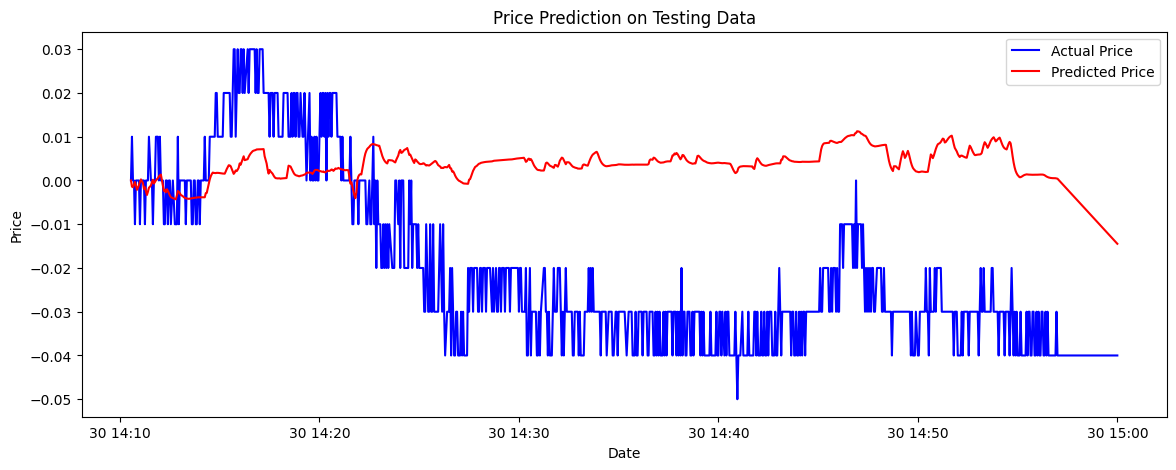

In [45]:

# 数据归一化
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

scaled_X = scaler_X.fit_transform(tick_data[['买一价', '买二价', '买三价', '买四价',
       '买五价', '卖一价', '卖二价', '卖三价', '卖四价', '卖五价', '买一量', '买二量', '买三量', '买四量',
       '买五量', '卖一量', '卖二量', '卖三量', '卖四量', '卖五量']].values)
scaled_Y = scaler_Y.fit_transform(tick_data[['最新价']].values)

scaled_data = np.concatenate([scaled_X, scaled_Y], axis=1)

# 创建训练和测试数据集
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# 创建数据集函数
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), :-1]
        X.append(a)
        Y.append(data[i + time_step, -1])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转换为Tensor
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(1)

# 创建LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 模型参数
input_size = 20

hidden_size = 50  # TODO
num_layers = 2   # TODO
output_size = 1

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# 预测
model.eval()
train_predict = model(X_train).detach().numpy()
test_predict = model(X_test).detach().numpy()

# 反归一化
train_predict = scaler_Y.inverse_transform(train_predict)
test_predict = scaler_Y.inverse_transform(test_predict)

# 计算均方误差
mse_train = mean_squared_error(scaler_Y.inverse_transform(y_train.detach().numpy()), train_predict)
mse_test = mean_squared_error(scaler_Y.inverse_transform(y_test.detach().numpy()), test_predict)


# 绘制测试数据的预测结果
plt.figure(figsize=(14, 5))
actual_price = scaler_Y.inverse_transform(test_data[time_step:, -1].reshape(-1, 1))
predicted_price = test_predict
plt.plot(tick_data['时间'][train_size + time_step:], actual_price - actual_price[0], color='blue', label='Actual Price')
plt.plot(tick_data['时间'][train_size + time_step:], predicted_price - predicted_price[0], color='red', label='Predicted Price')
plt.title('Price Prediction on Testing Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
